In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
import warnings
import seaborn as sns
warnings.simplefilter('ignore')
style.use('ggplot')
from collections import Counter
%matplotlib inline

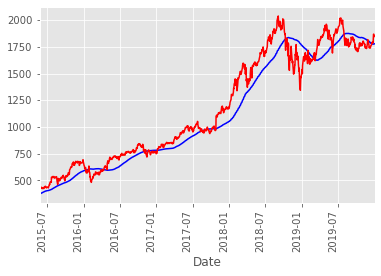

In [2]:
# example code to see amazon stock trend
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2019, 12, 31) # 4 years

df = web.DataReader('AMZN', 'yahoo', start, end)
df['100_moving_avg'] =  df['Adj Close'].rolling(window=100).mean()
df.dropna()['100_moving_avg'].plot(color='b')
df.dropna()['Adj Close'].plot(color='r')
plt.xticks(rotation=90)
plt.show()
# smoothing out the stock price trend

In [3]:
# automate web scraping the list of S&P 500 data from wikipedia
from bs4 import BeautifulSoup as bs
import requests
import pickle

In [4]:
def get_snp_500_tickers():
    sauce = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs(sauce.text, 'lxml')
    table_rows = [row for row in soup.find('table', {'class': 'wikitable sortable'}).find_all('tr')]
    tickers = [ticker.text.split('\n')[1].replace('.','-') for ticker in table_rows[1:]]
    # wikipedia saves '-' as '.' in ticker names
#   with open('sp500tickers.pickle', 'wb') as f: # to save as file for future uses
#       pickle.dump(tickers, f)
    return tickers

In [5]:
# getting stock data for all s&p 500 companies and making the dataframe
def get_stock_data():
    '''Collects and returns S&P 500 stock data. Tickers are scraped from Wikipedia.
    
    reload: If set to True, download data again. Also saves a copy to local.
    '''
    reload = input('Enter y for fetching new data, n for using existing data: ').lower()
    if reload == 'y':
        tickers = get_snp_500_tickers()
        dict_of_df = {}
        start = input('Specify start date in dd/mm/yyyy format: ')
        end = input('Specify end date in dd/mm/yyyy format: ')
        start = dt.datetime.strptime(start, '%d/%m/%Y')
        end = dt.datetime.strptime(end, '%d/%m/%Y')
        for ticker in tickers:
            dict_of_df[ticker] = web.DataReader(ticker, 'yahoo', start, end)
        df = pd.concat(dict_of_df).reset_index()
        df.rename({'level_0': 'Company'}, axis=1, inplace=True)
        save = input('Enter y to save data to local, n to skip').lower()
        if save == 'y':
            df.to_pickle(input('Enter file name as name.pickle: '))
        else:
            pass
        return df
    else:
        df = pd.read_pickle(input('Enter file name as name.pickle: '))
        return df

In [6]:
df = get_stock_data() # we already have previously collected data

Enter y for fetching new data, n for using existing data: n
Enter file name as name.pickle: default.pickle


In [7]:
df.sample(5)

,Company,Date,High,Low,Open,Close,Volume,Adj Close
363550,LNC,2015-06-17,61.369999,60.169998,61.099998,60.270000,1816100.0,53.869694
156618,CXO,2016-12-28,136.839996,133.860001,136.710007,135.039993,1018400.0,134.253113
138527,CTAS,2015-02-25,84.080002,83.010002,83.379997,83.699997,518400.0,79.128181
492192,RJF,2016-02-19,44.139999,42.669998,42.900002,43.869999,1533500.0,41.451820
592153,V,2018-09-04,147.860001,146.669998,146.929993,147.800003,7638100.0,146.382477


In [8]:
# for now we will work only with adjusted close
df = df.drop(df.columns[2:-1], axis=1)

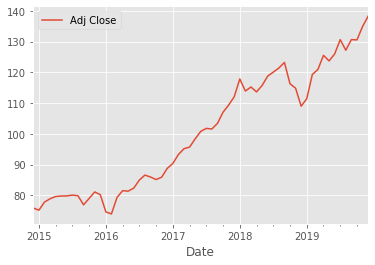

In [9]:
df.set_index('Date').resample('M').mean().plot()
plt.show()

In [10]:
monthend_mean = df.set_index('Date').resample('M').mean()

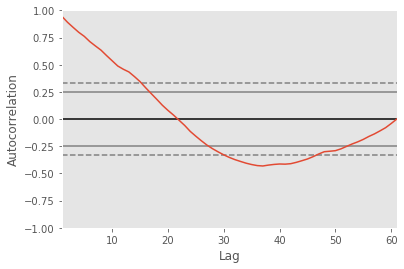

In [11]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(monthend_mean)
plt.show()
# autocorrelation is significant between 0 to ~1.5 years and ~3 to ~4.6 years
# these are the time periods worth investigating

In [12]:
df.sample(5)

,Company,Date,Adj Close
580100,VFC,2015-10-21,60.788670
370704,L,2018-11-12,48.461891
451093,PCAR,2017-05-26,55.146351
517133,SRE,2015-03-10,92.220314
494819,O,2016-07-26,60.243988


In [13]:
df.loc[df['Company'] == 'AAPL'].head()

,Company,Date,Adj Close
60432,AAPL,2014-12-31,101.178932
60433,AAPL,2015-01-02,100.216454
60434,AAPL,2015-01-05,97.393181
60435,AAPL,2015-01-06,97.402374
60436,AAPL,2015-01-07,98.768150


In [14]:
df.loc[df['Company'] == 'AMZN'].head()

,Company,Date,Adj Close
33993,AMZN,2014-12-31,310.350006
33994,AMZN,2015-01-02,308.519989
33995,AMZN,2015-01-05,302.190002
33996,AMZN,2015-01-06,295.290009
33997,AMZN,2015-01-07,298.420013


In [15]:
# as we can see, this data can be pivoted to give prices per company, column wise
df_pivot = df.pivot('Date','Company','Adj Close').reset_index().rename_axis(None, axis=1)
df_pivot.sample(5)

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
996,2018-12-14,68.603302,31.894270,163.467438,162.644440,79.950676,77.134323,316.190002,69.311180,153.000946,...,87.218040,71.104752,36.627121,23.426126,64.620178,89.791328,107.938675,171.889999,40.115643,87.763023
621,2017-06-20,58.886318,46.616383,122.970535,139.366852,63.005787,88.702850,144.460007,46.426403,121.093407,...,62.195114,72.965752,62.030853,25.916981,52.284889,70.570602,124.465004,105.830002,40.425564,62.044971
339,2016-05-06,40.016907,31.742601,149.546768,87.437325,53.245968,71.257912,94.940002,35.252445,108.322876,...,39.885254,75.071053,60.146835,22.590717,39.961201,54.214409,111.971931,63.450001,24.188063,46.170753
74,2015-04-20,41.259705,47.243286,151.188187,117.425117,52.178635,104.077751,69.330002,42.308704,85.675056,...,39.310108,71.429962,49.966396,30.684589,33.283875,52.566425,111.496490,96.129997,25.328793,45.518734
584,2017-04-27,54.103569,42.593857,142.483826,137.626251,58.449764,77.785126,130.919998,41.552433,115.312927,...,61.042866,71.361069,62.148361,26.054201,49.919304,63.027542,115.542488,94.160004,38.185749,55.509716


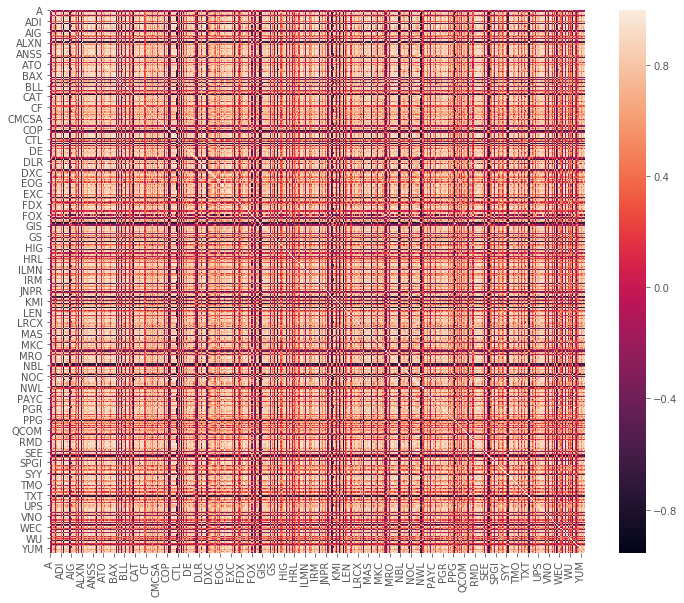

In [16]:
# correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df_pivot.corr())
plt.show()
# this graph shows that there is a definite relationship between the stock prices of these companies

In [17]:
# we will generate targets: buy, sell or hold
# this decision will be taken based on the direction of movement of the stock prices over a 7 day period

In [18]:
# example feature generation
# calculate % change in stock value after 7 days for, let's say Apple
# rows are in ascending order of dates, hence -ve shift will give future values
future_prices = df_pivot['AAPL'].shift(-7)
current_prices = df_pivot['AAPL']
percent_change = (future_prices - current_prices) / current_prices # for each date
print(percent_change)

0      -0.010237
1       0.008141
2       0.033412
3       0.005270
4      -0.016334
          ...   
1254         NaN
1255         NaN
1256         NaN
1257         NaN
1258         NaN
Name: AAPL, Length: 1259, dtype: float64


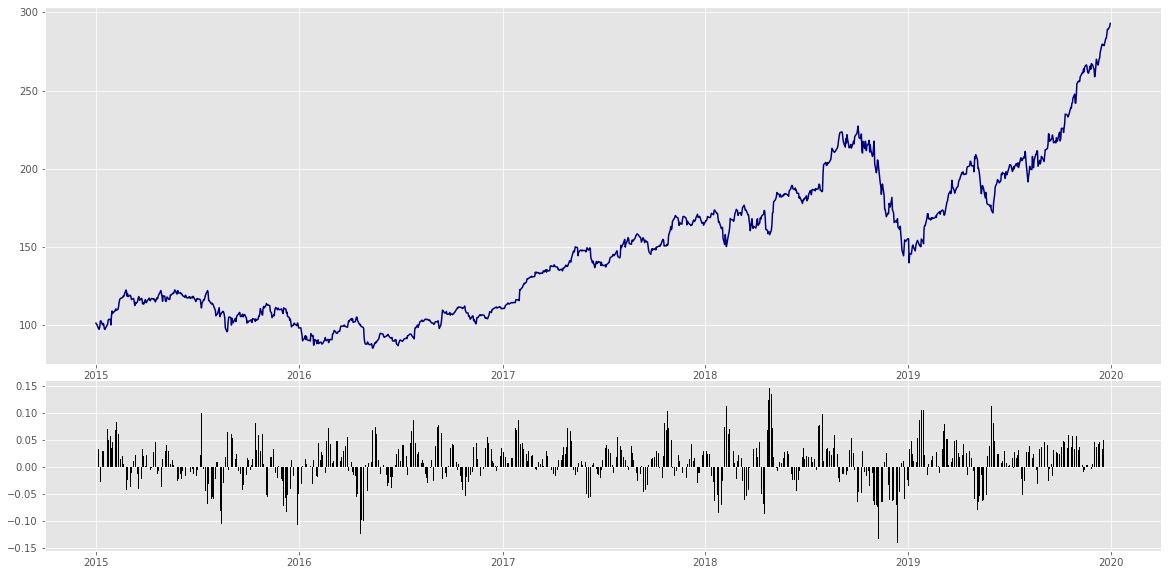

In [19]:
# visualising stock price movement and respective change
plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((6, 1), (0, 0), colspan=1, rowspan=4)
ax2 = plt.subplot2grid((6, 1), (4, 0), colspan=1, rowspan=2, sharex=ax1)
ax1.plot(df_pivot['Date'], current_prices, color='navy')
ax2.bar(df_pivot['Date'], percent_change, color='black')
plt.show()

In [20]:
def process_data(ticker):
    '''Returns a dataframe of stock percentage changes over a time period of 7 days (starting from one day), 
    for the given company ticker label, against all other companies. Also returns a list of company tickers.
    '''
    df = get_stock_data()
    tickers = list(set(df['Company']))
    df_pivot = df.pivot('Date','Company','Adj Close').reset_index().rename_axis(None, axis=1)
    df_pivot.fillna(0, inplace=True) # in case of missing data
    for i in range(1, 8):
        future_prices = df_pivot[ticker].shift(-i)
        current_prices = df_pivot[ticker]
        percent_change = (future_prices - current_prices) / current_prices
        df_pivot['{}_{}days'.format(ticker, i)] = percent_change
    df_pivot.fillna(0, inplace=True) # fill NaN values
    return tickers, df_pivot

In [21]:
# function to generate target labels
def buy_sell_hold(*args):
    '''Returns 1 for buy, -1 for sell, 0 for hold'''
    cols = [col for col in args]
    thres = 0.02 # threshold percentage change for decision making
    for col in cols:
        if col > thres:
            return 1
        if col < -thres:
            return -1
    return 0

In [22]:
def extract_featuresets(ticker):
    '''Returns a feature set, targets and the dataframe from where they were derived.
    
    ticker = company ticker symbol
    '''
    tickers, df = process_data(ticker)
    temp_list = []
    df['{}_target'.format(ticker)] = list(map(buy_sell_hold, 
                                             df['{}_1days'.format(ticker)], 
                                             df['{}_2days'.format(ticker)],
                                             df['{}_3days'.format(ticker)],
                                             df['{}_4days'.format(ticker)],
                                             df['{}_5days'.format(ticker)],
                                             df['{}_6days'.format(ticker)],
                                             df['{}_7days'.format(ticker)]))
    # mapping the buy_sell_hold function to the % change columns to generate class labels
    
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data distribution: {}'.format(Counter(str_vals))) # to check for balance in class distribution
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values # features
    y = df['{}_target'.format(ticker)].values # target
    
    return X, y, df

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

In [24]:
def ml_modelling(ticker):
    X, y, df = extract_featuresets(ticker)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    clf = VotingClassifier([('logreg', LogisticRegression()),
                            ('knn', KNeighborsClassifier()),
                            ('svm', SVC()),
                            ('dectree', DecisionTreeClassifier())
                           ])
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print('Predictions distribution: {}'.format(Counter(preds)))
    print('Accuracy: {}'.format(clf.score(X_test, y_test)))

In [25]:
ml_modelling('AMZN')

Enter y for fetching new data, n for using existing data: n
Enter file name as name.pickle: default.pickle
Data distribution: Counter({'1': 623, '-1': 395, '0': 241})
Predictions distribution: Counter({1: 317, -1: 90, 0: 9})
Accuracy: 0.4495192307692308
